In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [2]:
data1 = pd.read_csv('./data1.csv').to_numpy()
data2 = pd.read_csv('./data2.csv').to_numpy()
data3 = pd.read_csv('./data3.csv').to_numpy()

In [3]:
def center(S):
    res = []
    
    if type(S) is list:
        for s in S:
            c = np.array(s).sum(axis=0) / len(s)
            res.append(c)
    
    else:
        c = S.sum(axis=0) / len(S)
        res.append(c)
        
    return np.array(res)

In [4]:
def k_means(data, k, eps, A):
    n = len(data)
    D0 = np.inf
    if data.shape[1] == 2:
        tmp = np.empty((0, 2))
    else:
        tmp = np.empty((0, 3))
    # cnt = 1
    
    while 1:
        # print(f'Loop num : {cnt}')
        # print(f'Code book : {A}')
        D = 0
        S = [tmp for _ in range(k)]
        
        dist_list = np.sqrt(((data[:, :, np.newaxis] - A.T[np.newaxis, :, :])**2).sum(axis=1))
        near_point = dist_list.argmin(axis=1)
        for idx, x in zip(near_point, data):
            S[idx] = np.r_[S[idx], [x]]
        
        for i in range(dist_list.shape[1]):
            dist_list.T[i][near_point != i] = 0
        D = dist_list.sum() / n
        
        if (D0 - D) / D < eps:
            # print(f'Finish D : {D}')
            break
        
        # print(f'Again D : {D}')
        # print('====================================================================')
        D0 = D
        A = center(S)
        # cnt += 1
        
    # print(cnt)

    return A, S

In [5]:
def k_means_re(data, k, eps, A, D0=np.inf):
    n = len(data)
    
    if data.shape[1] == 2:
        tmp = np.empty((0, 2))
    else:
        tmp = np.empty((0, 3))    
    S = [tmp for _ in range(k)]
    
    dist_list = np.sqrt(((data[:, :, np.newaxis] - A.T[np.newaxis, :, :])**2).sum(axis=1))
    near_point = dist_list.argmin(axis=1)
    for idx, x in zip(near_point, data):
        S[idx] = np.r_[S[idx], [x]]
        
    for i in range(dist_list.shape[1]):
        dist_list.T[i][near_point != i] = 0
    D = dist_list.sum() / n
    
    if (D0 - D) / D < eps:
        return A, S
    else:
        return k_means_re(data, k, eps, center(S), D)

In [43]:
def lbg(data, k, eps, A, M=1):
    delta = np.array([10 for _ in range(data.shape[1])])
    
    if data.shape[1] == 2:
        tmp = np.empty((0, 2))
    else:
        tmp = np.empty((0, 3))
    for y in A:
        tmp = np.r_[tmp, [y + delta]]
        tmp = np.r_[tmp, [y - delta]]
    A = tmp
    
    A, S = k_means(data, 2*M, 0.001, A)
    if A.shape[0] == k:
        return A
    else:
        M = 2*M
        return lbg(data, k, eps, A, M)

In [7]:
def k_means_pp(data, k):
    n = len(data)
    first_idx = np.random.choice(n, 1, replace=False)
    A = data[first_idx]
    P = ((A - data) ** 2).sum(axis=1) / ((A - data) ** 2).sum()
    
    next_idx = np.random.choice(n, 1, replace=False, p=P)
    A = np.r_[A, data[next_idx]]
    
    if k > 2:
        for _ in range(k-2):
            dist_list = ((data[:, :, np.newaxis] - A.T[np.newaxis, :, :])**2).sum(axis=1)
            near_point = dist_list.argmin(axis=1)
            for i in range(dist_list.shape[1]):
                dist_list.T[i][near_point != i] = 0
                
            P = dist_list.sum(axis=1) / dist_list.sum()
            next_idx = np.random.choice(n, 1, replace=False, p=P)
            A = np.r_[A, data[next_idx]]
            
    return A

In [8]:
def minimax(data, k):
    n = len(data)
    first_idx = np.random.choice(n, 1, replace=False)
    A = data[first_idx]
    next_idx = ((A - data) ** 2).sum(axis=1).argmax()
    A = np.r_[A, [data[next_idx]]]
    
    if k > 2:
        for _ in range(k-2):
            dist_list = ((data[:, :, np.newaxis] - A.T[np.newaxis, :, :])**2).sum(axis=1)
            near_point = dist_list.argmin(axis=1)
            for i in range(dist_list.shape[1]):
                dist_list.T[i][near_point != i] = 0
            
            next_idx = dist_list.sum(axis=1).argmax()
            A = np.r_[A, [data[next_idx]]]
            
    return A

In [9]:
def random_choice(data, k):
    n = len(data)
    first_idx = np.random.choice(n, k, replace=False)
    A = data[first_idx]
    return A

In [10]:
import time

In [16]:
K = 4

In [22]:
time_m = 0
for _ in range(1000):
    start = time.time()
    A_minimax = minimax(data1, K)
    A_m, S_m = k_means(data1, K, 0.001, A_minimax)
    tmp = time.time() - start
    time_m += tmp

In [44]:
time_l = 0
for _ in range(1000):
    start = time.time()
    A_lbg = lbg(data1, K, 0.001, center(data1))
    A_l, S_l = k_means(data1, K, 0.001, A_lbg)
    tmp = time.time() - start
    time_l += tmp

In [24]:
time_r = 0
for _ in range(1000):
    start = time.time()
    A_random = random_choice(data1, K)
    A_r, S_r = k_means(data1, K, 0.001, A_random)
    tmp = time.time() - start
    time_r += tmp

In [25]:
time_p = 0
for _ in range(1000):
    start = time.time()
    A_pp = k_means_pp(data1, K)
    A_p, S_p = k_means(data1, K, 0.001, A_pp)
    tmp = time.time() - start
    time_p += tmp

In [45]:
print(time_m / 1000)
print(time_l / 1000)
print(time_r / 1000)
print(time_p / 1000)

0.037967638731002805
0.05579531311988831
0.03369012093544006
0.03282694864273071


In [40]:
time_list = [[] for _ in range(4)]
for _ in range(1000):
    start = time.time()
    A_minimax = minimax(data1, K)
    A_m, S_m = k_means(data1, K, 0.001, A_minimax)
    tmp = time.time() - start
    time_list[0].append(tmp)
    
    start = time.time()
    A_lbg = lbg(data1, K, 0.001, center(data1))
    A_l, S_l = k_means(data1, K, 0.001, A_lbg)
    tmp = time.time() - start
    time_list[1].append(tmp)
    
    start = time.time()
    A_random = random_choice(data1, K)
    A_r, S_r = k_means(data1, K, 0.001, A_random)
    tmp = time.time() - start
    time_list[2].append(tmp)
    
    start = time.time()
    A_pp = k_means_pp(data1, K)
    A_p, S_p = k_means(data1, K, 0.001, A_pp)
    tmp = time.time() - start
    time_list[3].append(tmp)

<ipython-input-42-9b62d54dfea9>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Random', 'k-means++', 'Minimax', 'LBG'], fontsize=14)
<ipython-input-42-9b62d54dfea9>:5: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(box_data, whis="range")


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe601215820>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe601215ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe5e1fbfd90>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe60120efd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe60120e580>,
 'means': []}

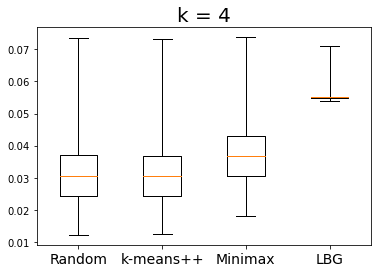

In [42]:
box_data = (time_list[2], time_list[3], time_list[0], time_list[1])
fig, ax = plt.subplots()
ax.set_title('k = 4', fontsize=20)
ax.set_xticklabels(['Random', 'k-means++', 'Minimax', 'LBG'], fontsize=14)
ax.boxplot(box_data, whis="range")